# 4. **ML Modeling - Price Prediction Regression Model**
---


###  **Machine Learning Regression Model for Price Prediction:**
To address the business problem, the proposed solution involves creating a robust machine learning model for predicting the resale price of used cars. This model will take into account various features such as the make, model, mileage, year of manufacture, and any other relevant factors that influence the pricing of used cars.

The model's implementation aims to empower purchasing agents with a tool that can provide a reasonable estimate of the resale value of a potential acquisition. This ensures that the company can make well-informed decisions when acquiring used cars, optimizing the balance between competitive pricing and maintaining healthy profit margins.




###  **Model Evaluation:**
####  Evaluation Metrics:

*  **Root Mean Squared Error (RMSE):**
    
    *   RMSE is the square root of the average squared difference between the predicted and actual prices.
    *   Business Relation: A low RMSE indicates that, on average, the model's predictions are close to the true prices. This is crucial for the business, as it directly aligns with the goal of accurate price prediction, helping purchasing agents make informed decisions.

*   **Mean Absolute Error (MAE):**
    
    *   MAE represents the average absolute difference between the predicted prices and the actual prices.
    *   Business Relation: A low MAE indicates that, on average, the model's predictions are close to the true prices. This is crucial for the business, as it directly aligns with the goal of accurate price prediction, helping purchasing agents make informed decisions.
*   **Mean Squared Error (MSE):**
    
    *   MSE calculates the average squared difference between predicted and actual prices.
    *   Business Relation: MSE gives more weight to large errors. A low MSE indicates that the model is effective in minimizing significant deviations, which is important for ensuring that extreme pricing errors are minimized, contributing to more consistent and reliable predictions.
*   **R-squared (R2):**
    
    *   R2 measures the proportion of the variance in the target variable explained by the model.
    *   Business Relation: A high R2 suggests that a significant portion of the variability in used car prices is captured by the model. This is important for business success as it indicates that the model is effectively leveraging the provided features to predict prices, contributing to better decision-making.

In [1]:
#Library Imports

import pandas as pd 
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold

from sklearn.preprocessing import OneHotEncoder, RobustScaler
import category_encoders as ce
from category_encoders import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.compose import TransformedTargetRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


In [2]:
#Load Preprocessed Data
cars = pd.read_csv("Combined Dataset.csv")
cars.head()

,Unnamed: 0,model,year,price,transmission,mileage,fuelType,engineSize,tax,mpg,brand
0,0,C Class,2020,30495,Automatic,1200,Diesel,2.0,145.0,61.4,Mercedes
1,1,C Class,2020,29989,Automatic,1000,Petrol,1.5,145.0,46.3,Mercedes
2,2,C Class,2020,37899,Automatic,500,Diesel,2.0,145.0,61.4,Mercedes
3,3,C Class,2019,30399,Automatic,5000,Diesel,2.0,145.0,61.4,Mercedes
4,5,C Class,2019,29899,Automatic,4500,Diesel,2.0,145.0,61.4,Mercedes


## 4.1 Feature Selection

All columns in the dataset are potential features for the model. 
- The target variable is the price of the used car.
- The features are the remaining columns in the dataset.

In [3]:
cars.drop(cars[cars['fuelType'] == "Other"].index, inplace=True)

In [4]:
cars.drop(cars[cars['transmission'] == "Other"].index, inplace=True)

In [5]:
#Drop Unnecessary Columns
cars.drop(['Unnamed: 0'], axis=1, inplace=True)

## 4.2 Train Test Split

In [6]:
#Column Selection
X = cars.drop(['price'], axis = 1)
y = cars['price']

# Data Splitting dengan proporsi test size 80:20
xtrain, xtest, ytrain, ytest = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state= 42)

## 4.3 Columns Encoding

Encoding is a technique used in machine learning to convert categorical data into numerical format. In this project, we've aplied three methods: one-hot encoding for nominal categories, robust scaler Using the robust scaler to standardize the scale of numerical data. One-hot encoding is suitable for categories without a specific order and a limited set of unique values. Here's a breakdown of how each encoding type is applied.

- Onehot: Transmission, FuelType
- Robust: Mileage, Mpg,
- Binary: Model, Brand

In [7]:
transform = ColumnTransformer([
    ('Scaler', RobustScaler(), ['mileage', 'mpg']),
    ('OHE', OneHotEncoder(drop='first'), ['transmission', 'fuelType']),
    ('Binary Encoder', ce.BinaryEncoder(), ['model', 'brand'])
],remainder = "passthrough")

transform

ColumnTransformer(remainder='passthrough',
                  transformers=[('Scaler', RobustScaler(), ['mileage', 'mpg']),
                                ('OHE', OneHotEncoder(drop='first'),
                                 ['transmission', 'fuelType']),
                                ('Binary Encoder', BinaryEncoder(),
                                 ['model', 'brand'])])

## 4.4 Model Benchmarking

In the initial phase, we will perform modeling on the 7 selected benchmark models. The results from these benchmark models, in terms of scoring, will be based on the chosen evaluation metrics: RMSE, MAE, and MAPE. The selection of these three metrics is to compare the model's performance by examining its residuals.

THe benchmark models are:
- Linear Regression
- KNN Regressor
- Decision Tree Regressor
- Random Forest Regressor
- Gradient Boosting Regressor
- XGBoost Regressor
- AdaBoost Regressor

In [8]:
# Define the algorithm

lr = LinearRegression()
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor(random_state= 42)
rf = RandomForestRegressor(random_state= 42)
ada = AdaBoostRegressor(random_state= 42)
xgb = XGBRegressor(random_state= 42)
gbr = GradientBoostingRegressor(random_state= 42)

models = [lr, knn, dt, rf, ada, xgb, gbr]

score_rmse = []
nilai_mean_rmse = []
nilai_std_rmse = []

score_mae = []
nilai_mean_mae = []
nilai_std_mae = []

score_mape = []
nilai_mean_mape = []
nilai_std_mape = []

score_r2 = []
nilai_mean_r2 = []
nilai_std_r2 = []

# Finding the best algorithm based on each metrics

for i in models:
    
    crossval = KFold(n_splits=5, shuffle=True, random_state=42)

    estimator = Pipeline([
        ('preprocessing', transform),
        ('model', i)
    ])

    # RMSE
    model_cv_rmse = cross_val_score(
        estimator, 
        xtrain, 
        ytrain, 
        cv=crossval, 
        scoring='neg_root_mean_squared_error', 
        error_score='raise'
        )

    print(model_cv_rmse, i)

    score_rmse.append(model_cv_rmse)
    nilai_mean_rmse.append(model_cv_rmse.mean())
    nilai_std_rmse.append(model_cv_rmse.std())

    # MAE
    model_cv_mae = cross_val_score(
        estimator, 
        xtrain, 
        ytrain, 
        cv=crossval, 
        scoring='neg_mean_absolute_error', 
        error_score='raise'
        )

    print(model_cv_mae, i)

    score_mae.append(model_cv_mae)
    nilai_mean_mae.append(model_cv_mae.mean())
    nilai_std_mae.append(model_cv_mae.std())

    # MAPE
    model_cv_mape = cross_val_score(
        estimator, 
        xtrain, 
        ytrain, 
        cv=crossval, 
        scoring='neg_mean_absolute_percentage_error', 
        error_score='raise'
        )

    print(model_cv_mape, i)

    score_mape.append(model_cv_mape)
    nilai_mean_mape.append(model_cv_mape.mean())
    nilai_std_mape.append(model_cv_mape.std())
    
    
    #R2 Score
    model_cv_r2 = cross_val_score(
        estimator, 
        xtrain, 
        ytrain, 
        cv=crossval, 
        scoring='r2', 
        error_score='raise'
        )

    print(model_cv_mape, i)

    score_r2.append(model_cv_r2)
    nilai_mean_r2.append(model_cv_r2.mean())
    nilai_std_r2.append(model_cv_r2.std())

[-4622.88439086 -4126.64746313 -4544.04813958 -4601.85232187
 -4759.73384645] LinearRegression()
[-2839.38587926 -2749.38700501 -2841.84932822 -2790.19230806
 -3108.09920699] LinearRegression()
[-0.20523344 -0.21098993 -0.21695972 -0.20322684 -0.22319675] LinearRegression()
[-0.20523344 -0.21098993 -0.21695972 -0.20322684 -0.22319675] LinearRegression()
[-2709.94609992 -2207.50717367 -2430.85526493 -2521.60400272
 -2474.68754379] KNeighborsRegressor()
[-1398.57869282 -1337.58263149 -1370.96969389 -1379.0409606
 -1389.00744123] KNeighborsRegressor()
[-0.08159336 -0.08122058 -0.08189901 -0.08105989 -0.08222317] KNeighborsRegressor()
[-0.08159336 -0.08122058 -0.08189901 -0.08105989 -0.08222317] KNeighborsRegressor()
[-2903.75455707 -2383.00647865 -2459.873402   -2663.90184474
 -2729.93680939] DecisionTreeRegressor(random_state=42)
[-1541.31977819 -1476.441929   -1484.69426905 -1524.45556421
 -1561.29881466] DecisionTreeRegressor(random_state=42)
[-0.09133001 -0.09096575 -0.09044498 -0.092

In [9]:
pd.DataFrame({
    'Model': ['Linear Regression', 'KNN Regressor', 'DecisionTree Regressor',
              'RandomForest Regressor', 'AdaBoost Regressor', 'XGBoost Regressor', 'GradientBoosting Regressor'],
    'Mean_RMSE': nilai_mean_rmse,
    'Std_RMSE': nilai_std_rmse,
    'Mean_MAE': nilai_mean_mae,
    'Std_MAE': nilai_std_mae,
    'Mean_MAPE': nilai_mean_mape,
    'Std_MAPE': nilai_std_mape,
    'Mean_R2' : nilai_mean_r2,
    'Std_R2' : nilai_std_r2
}).sort_values('Mean_MAPE',ascending = False)

,Model,Mean_RMSE,Std_RMSE,Mean_MAE,Std_MAE,Mean_MAPE,Std_MAPE,Mean_R2,Std_R2
3,RandomForest Regressor,-2034.937911,126.456369,-1224.978660,18.793410,-0.074430,0.000468,0.957555,0.004629
5,XGBoost Regressor,-2021.031567,93.466623,-1286.466896,8.205742,-0.078983,0.001327,0.958110,0.004074
1,KNN Regressor,-2468.920017,161.671296,-1375.035884,20.903535,-0.081599,0.000427,0.937673,0.005579
2,DecisionTree Regressor,-2628.094618,187.621409,-1517.642071,32.545286,-0.091752,0.001085,0.929231,0.008206
6,GradientBoosting Regressor,-2978.950510,131.513704,-1995.736784,62.115456,-0.124373,0.003629,0.909150,0.006843
0,Linear Regression,-4531.033232,214.221002,-2865.782746,125.895793,-0.211921,0.007399,0.790060,0.013431
4,AdaBoost Regressor,-6768.613100,654.318926,-5677.450474,674.820741,-0.486858,0.056434,0.527289,0.084034


> From the benchmarked model, we will select the top 3 models with the best performance to be further tuned and optimized.

## 4.5 Benchmarked Model Tuning & Evaluation

From the benchmarked model, we will select the top 3 models with the best performance to be further tuned and optimized. The tuning process will be done using the GridSearchCV method. The evaluation of the tuned model will be based on the same evaluation metrics as the benchmarked model.

In [10]:
# Benchmarking top 3 Best Model

rf = RandomForestRegressor(random_state= 42)
xgb = XGBRegressor(random_state= 42)
dt = DecisionTreeRegressor(random_state= 42)

models = [rf, xgb, dt]

score_rmse = []
score_mae = []
score_mape = []
score_r2 = []

# Finding the best algorithm based on each metrics

for i in models:
    model = Pipeline([
        ('preprocessing', transform),
        ('model', i)
    ])
    
    model.fit(xtrain, ytrain)
    y_pred = model.predict(xtest)
    
    score_rmse.append(np.sqrt(mean_squared_error(ytest, y_pred)))
    score_mae.append(mean_absolute_error(ytest, y_pred))
    score_mape.append(mean_absolute_percentage_error(ytest, y_pred))
    score_r2.append(r2_score(ytest, y_pred))
    
# Model Evaluation dataframe     
score_before_tuning = pd.DataFrame({'RMSE': score_rmse, 'MAE': score_mae, 'MAPE': score_mape, 'R2': score_r2}, index=['Random Forest', 'XGBoost', 'Decission Tree'])
score_before_tuning

,RMSE,MAE,MAPE,R2
Random Forest,1816.099520,1161.306978,0.070698,0.963375
XGBoost,1882.616960,1248.716083,0.075327,0.960642
Decission Tree,2447.036929,1453.665280,0.087721,0.933506


> ###  Random Forest are found to be Best Model before Tuning, with **R2 of 95.4%** and **MAPE of 7.1%**

### 4.5.1 Random Forest Hyperparameter Tuning

In [11]:
param_grid = {
    'model__n_estimators': [10, 50, 100, 200],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Create a pipeline with data preprocessing and Random Forest model
pipe_rf = Pipeline([
    ('prep', transform),
    ('model', rf)
])

# Hyperparameter tuning with GridSearchCV
grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid,
    cv=5,
    scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'r2'],
    refit='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
)

In [12]:
#Fit the model from the best parameter
grid_rf.fit(xtrain, ytrain)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


/Users/Dwika/My Projects/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('Scaler',
                                                                         RobustScaler(),
                                                                         ['mileage',
                                                                          'mpg']),
                                                                        ('OHE',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['transmission',
                                                                          'fuelType']),
                                                                        ('Binary '
                                                                         'Encoder',
                                                                         BinaryEncoder(),
                                                                         ['model',
                                                                          'brand'])])),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 10, 20, 30],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10],
                         'model__n_estimators': [10, 50, 100, 200]},
             refit='neg_root_mean_squared_error',
             scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error', 'r2'],
             verbose=1)

In [13]:
#Display the best parameter and score
pd.DataFrame(grid_rf.cv_results_).sort_values(\
    by=['rank_test_neg_root_mean_squared_error','rank_test_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_percentage_error', 'rank_test_r2']).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__min_samples_leaf,param_model__min_samples_split,param_model__n_estimators,params,split0_test_neg_root_mean_squared_error,...,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2
75,35.038960,0.524766,1.001544,0.095620,20,1,2,200,"{'model__max_depth': 20, 'model__min_samples_l...",-2161.843945,...,0.001353,7,0.953830,0.960298,0.956711,0.963589,0.963696,0.959625,0.003868,1
79,32.788956,0.443243,0.717440,0.024880,20,1,5,200,"{'model__max_depth': 20, 'model__min_samples_l...",-2166.723174,...,0.001419,1,0.953621,0.960244,0.956459,0.963530,0.964122,0.959595,0.004048,2
115,34.170493,0.392862,0.799976,0.019508,30,1,5,200,"{'model__max_depth': 30, 'model__min_samples_l...",-2169.119248,...,0.001357,8,0.953519,0.959795,0.956291,0.963002,0.963791,0.959280,0.003914,3
7,30.128770,0.252568,0.669878,0.029014,None,1,5,200,"{'model__max_depth': None, 'model__min_samples...",-2168.375428,...,0.001363,9,0.953551,0.959778,0.956308,0.962975,0.963745,0.959272,0.003886,4
78,16.748892,0.281094,0.387603,0.023622,20,1,5,100,"{'model__max_depth': 20, 'model__min_samples_l...",-2190.295388,...,0.001453,2,0.952607,0.959947,0.956072,0.963343,0.964223,0.959238,0.004386,5


In [14]:
# Best parameter for Random Forest
print('Random Forest (by GridSearchCV')
print('Best_score:', grid_rf.best_score_)
print('Best_params:', grid_rf.best_params_)

Random Forest (by GridSearchCV
Best_score: -1986.615529295901
Best_params: {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}


In [15]:
# Model Random Forest
model = {'RF': RandomForestRegressor(random_state= 42)}

# Define model terhadap estimator terbaik
rf_tuning = grid_rf.best_estimator_

# Fitting model
rf_tuning.fit(xtrain, ytrain)

# Predict test set
y_pred_rf_tuning = rf_tuning.predict(xtest)

# Simpan nilai metrics RMSE, MAE & MAPE setelah tuning
rmse_rf_tuning = np.sqrt(mean_squared_error(ytest, y_pred_rf_tuning))
mae_rf_tuning = mean_absolute_error(ytest, y_pred_rf_tuning)
mape_rf_tuning = mean_absolute_percentage_error(ytest, y_pred_rf_tuning)
r2_rf_tuning = r2_score(ytest, y_pred_rf_tuning)

score_after_tuning_rf = pd.DataFrame({'RMSE': rmse_rf_tuning, 'MAE': mae_rf_tuning, 'MAPE': mape_rf_tuning, 'R2': r2_rf_tuning}, index=model.keys())
score_after_tuning_rf

,RMSE,MAE,MAPE,R2
RF,1791.897651,1145.027582,0.069629,0.964344


### 4.5.2 XGBOOST Hyperparameter Tuning

In [16]:
param_grid_xgb = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [3, 6, 9],  # XGBoost uses maximum depth instead of None
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0],
}

# Create an XGBoost Regressor
xgb = XGBRegressor(random_state=42)

# Create a pipeline with data preprocessing and XGBoost model
pipe_xgb = Pipeline([
    ('prep', transform),
    ('model', xgb)
])

# Hyperparameter tuning with GridSearchCV
grid_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=param_grid_xgb,
    cv=5,
    scoring={
        'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
        'neg_mean_absolute_error': 'neg_mean_absolute_error',
        'neg_mean_absolute_percentage_error': 'neg_mean_absolute_percentage_error',
        'r2': 'r2'
    },
    refit='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
)
grid_xgb.fit(xtrain, ytrain)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('Scaler',
                                                                         RobustScaler(),
                                                                         ['mileage',
                                                                          'mpg']),
                                                                        ('OHE',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['transmission',
                                                                          'fuelType']),
                                                                        ('Binary '
                                                                         'Encoder',
                                                                         BinaryEncoder(),
                                                                         ['model',
                                                                          'brand'])])),
                                       ('model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_b...
                         'model__learning_rate': [0.01, 0.1, 0.2],
                         'model__max_depth': [3, 6, 9],
                         'model__n_estimators': [50, 100, 200],
                         'model__subsample': [0.8, 1.0]},
             refit='neg_root_mean_squared_error',
             scoring={'neg_mean_absolute_error': 'neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error': 'neg_mean_absolute_percentage_error',
                      'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
                      'r2': 'r2'},
             verbose=1)

In [17]:
pd.DataFrame(grid_xgb.cv_results_).sort_values(\
    by=['rank_test_neg_root_mean_squared_error','rank_test_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_percentage_error', 'rank_test_r2']).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__colsample_bytree,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,params,...,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2
35,1.893387,0.056295,0.182351,0.013981,0.8,0.1,9,200,1.0,"{'model__colsample_bytree': 0.8, 'model__learn...",...,0.001428,1,0.959024,0.964697,0.960143,0.966790,0.966936,0.963518,0.003328,1
34,2.031614,0.040668,0.186926,0.006340,0.8,0.1,9,200,0.8,"{'model__colsample_bytree': 0.8, 'model__learn...",...,0.001360,2,0.958513,0.964875,0.959699,0.967098,0.966530,0.963343,0.003555,2
53,1.796549,0.068186,0.193920,0.019232,0.8,0.2,9,200,1.0,"{'model__colsample_bytree': 0.8, 'model__learn...",...,0.001191,3,0.960763,0.964703,0.958448,0.966779,0.965702,0.963279,0.003157,3
51,1.031112,0.026304,0.089181,0.008030,0.8,0.2,9,100,1.0,"{'model__colsample_bytree': 0.8, 'model__learn...",...,0.001077,8,0.960676,0.964749,0.958585,0.966660,0.965503,0.963235,0.003077,4
88,2.134489,0.032960,0.192003,0.017996,1.0,0.1,9,200,0.8,"{'model__colsample_bytree': 1.0, 'model__learn...",...,0.001102,4,0.959349,0.964440,0.958547,0.965101,0.966727,0.962833,0.003268,5


In [18]:
print('XGBoost (by GridSearchCV')
print('Best_score:', grid_xgb.best_score_)
print('Best_params:', grid_xgb.best_params_)

XGBoost (by GridSearchCV
Best_score: -1888.6812812925345
Best_params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 9, 'model__n_estimators': 200, 'model__subsample': 1.0}


In [19]:
# Model XGBoost Regressor
model = {'XGB': XGBRegressor(random_state= 42)}

# Define model terhadap estimator terbaik
xgb_tuning = grid_xgb.best_estimator_

# Fitting model
xgb_tuning.fit(xtrain, ytrain)

# Predict test set
y_pred_xgb_tuning = xgb_tuning.predict(xtest)

# Simpan nilai metrics RMSE, MAE & MAPE setelah tuning
rmse_xgb_tuning = np.sqrt(mean_squared_error(ytest, y_pred_xgb_tuning))
mae_xgb_tuning = mean_absolute_error(ytest, y_pred_xgb_tuning)
mape_xgb_tuning = mean_absolute_percentage_error(ytest, y_pred_xgb_tuning)
r2_xgb_tuning = r2_score(ytest, y_pred_xgb_tuning)

score_after_tuning_xgb = pd.DataFrame({'RMSE': rmse_xgb_tuning, 'MAE': mae_xgb_tuning, 'MAPE': mape_xgb_tuning, 'R2': r2_xgb_tuning}, index=model.keys())
score_after_tuning_xgb

,RMSE,MAE,MAPE,R2
XGB,1714.876641,1109.504733,0.066939,0.967344


### 4.5.3 Decision Tree Hyperparameter Tuning

In [20]:
param_grid_dt = {
    'model__max_depth': [None, 3, 6, 9],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Create a Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=2023)

# Create a pipeline with data preprocessing and Decision Tree model
pipe_dt = Pipeline([
    ('prep', transform),
    ('model', dt)
])

# Hyperparameter tuning with GridSearchCV
grid_dt = GridSearchCV(
    estimator=pipe_dt,
    param_grid=param_grid_dt,
    cv=5,
    scoring={
        'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
        'neg_mean_absolute_error': 'neg_mean_absolute_error',
        'neg_mean_absolute_percentage_error': 'neg_mean_absolute_percentage_error',
        'r2': 'r2'
    },
    refit='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
)

# Fit the model
grid_dt.fit(xtrain, ytrain)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('Scaler',
                                                                         RobustScaler(),
                                                                         ['mileage',
                                                                          'mpg']),
                                                                        ('OHE',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['transmission',
                                                                          'fuelType']),
                                                                        ('Binary '
                                                                         'Encoder',
                                                                         BinaryEncoder(),
                                                                         ['model',
                                                                          'brand'])])),
                                       ('model',
                                        DecisionTreeRegressor(random_state=2023))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 3, 6, 9],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10]},
             refit='neg_root_mean_squared_error',
             scoring={'neg_mean_absolute_error': 'neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error': 'neg_mean_absolute_percentage_error',
                      'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
                      'r2': 'r2'},
             verbose=1)

In [21]:
pd.DataFrame(grid_dt.cv_results_).sort_values(\
    by=['rank_test_neg_root_mean_squared_error','rank_test_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_percentage_error', 'rank_test_r2']).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__min_samples_leaf,param_model__min_samples_split,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,...,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2
8,0.353455,0.013704,0.028134,0.004482,None,4,10,"{'model__max_depth': None, 'model__min_samples...",-2663.965467,-2423.906457,...,0.001293,1,0.929892,0.936631,0.938683,0.936753,0.943030,0.936998,0.004241,1
6,0.351729,0.013863,0.025492,0.003276,None,4,2,"{'model__max_depth': None, 'model__min_samples...",-2682.880591,-2452.224136,...,0.001291,2,0.928893,0.935142,0.937818,0.938414,0.942235,0.936500,0.004427,2
7,0.356350,0.017721,0.026529,0.005986,None,4,5,"{'model__max_depth': None, 'model__min_samples...",-2682.880591,-2452.224136,...,0.001291,2,0.928893,0.935142,0.937818,0.938414,0.942235,0.936500,0.004427,2
5,0.377627,0.019755,0.028109,0.006575,None,2,10,"{'model__max_depth': None, 'model__min_samples...",-2811.569002,-2513.690822,...,0.000979,4,0.921908,0.931850,0.938840,0.940654,0.939111,0.934473,0.006979,4
2,0.360477,0.019344,0.022781,0.002203,None,1,10,"{'model__max_depth': None, 'model__min_samples...",-2980.108578,-2324.942066,...,0.001015,5,0.912265,0.941700,0.937867,0.935656,0.939063,0.933310,0.010702,5


In [22]:
print('Decission Tree (by GridSearchCV')
print('Best_score:', grid_dt.best_score_)
print('Best_params:', grid_dt.best_params_)

Decission Tree (by GridSearchCV
Best_score: -2482.5540198215876
Best_params: {'model__max_depth': None, 'model__min_samples_leaf': 4, 'model__min_samples_split': 10}


In [23]:
# Model DT Regressor
model = {'DT': DecisionTreeRegressor(random_state= 2023)}

# Define model terhadap estimator terbaik
dt_tuning = grid_dt.best_estimator_

# Fitting model
dt_tuning.fit(xtrain, ytrain)

# Predict test set
y_pred_dt_tuning = dt_tuning.predict(xtest)

# Simpan nilai metrics RMSE, MAE & MAPE setelah tuning
rmse_dt_tuning = np.sqrt(mean_squared_error(ytest, y_pred_dt_tuning))
mae_dt_tuning = mean_absolute_error(ytest, y_pred_dt_tuning)
mape_dt_tuning = mean_absolute_percentage_error(ytest, y_pred_dt_tuning)
r2_dt_tuning = r2_score(ytest, y_pred_dt_tuning)

score_after_tuning_dt = pd.DataFrame({'RMSE': rmse_dt_tuning, 'MAE': mae_dt_tuning, 'MAPE': mape_dt_tuning, 'R2': r2_dt_tuning}, index=model.keys())
score_after_tuning_dt

,RMSE,MAE,MAPE,R2
DT,2155.370816,1331.942368,0.080347,0.948412


---

### 4.5.4 Model Evaluation

In [24]:
# Model Evaluation dataframe
# Create dataframe from tuned models and rank them
score_after_tuning = pd.concat([score_after_tuning_rf, score_after_tuning_xgb, score_after_tuning_dt]).sort_values('R2', ascending=False)
score_after_tuning

,RMSE,MAE,MAPE,R2
XGB,1714.876641,1109.504733,0.066939,0.967344
RF,1791.897651,1145.027582,0.069629,0.964344
DT,2155.370816,1331.942368,0.080347,0.948412


> #### XGBOOST are found to be Best Model after Tuning

In [31]:
score_after_tuning.loc['XGB']

RMSE    1714.876641
MAE     1109.504733
MAPE       0.066939
R2         0.967344
Name: XGB, dtype: float64

Root Mean Squared Error (RMSE)

- Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit. RMSE is a good measure of how accurately the model predicts the response, and it is the most important criterion for fit if the main purpose of the model is prediction.
- The RMSE of the final model is 1714.87, the price listed in the data ranges from 495 to 159,999.0, so the RMSE is fairly acceptable.

Mean Absolute Error (MAE)

- The **Mean Absolute Error (MAE)** measures the average absolute magnitude between the actual values and the predicted values by regression model.
In general, the lower the MAE, the better the model predicts. In Our case, the MAE of Final model is 1,134.33 , and the median price of used cars in the data is 15,490.0 and the maximum is 159,999.0 so the MAE is fairly acceptable.

Mean Absolute Percentage Error (MAPE)
- **MAPE** represents the error values in percentages. For our model, we obtained 7.02% of MAPE means that the actual and predicted values are off by +/- 7.02%.

R squared (R2)
- **R2** is the coefficient determination that presents how well the model fits the dependent variables. R2 can be interpreted as the proportion of the information of the data explained by the model. The higher the R2, the better the model fits the observations. For our model, we obtained the value of R-squared is 0.9678 which means that 96.78% of the variability in used car prices is captured by the model.

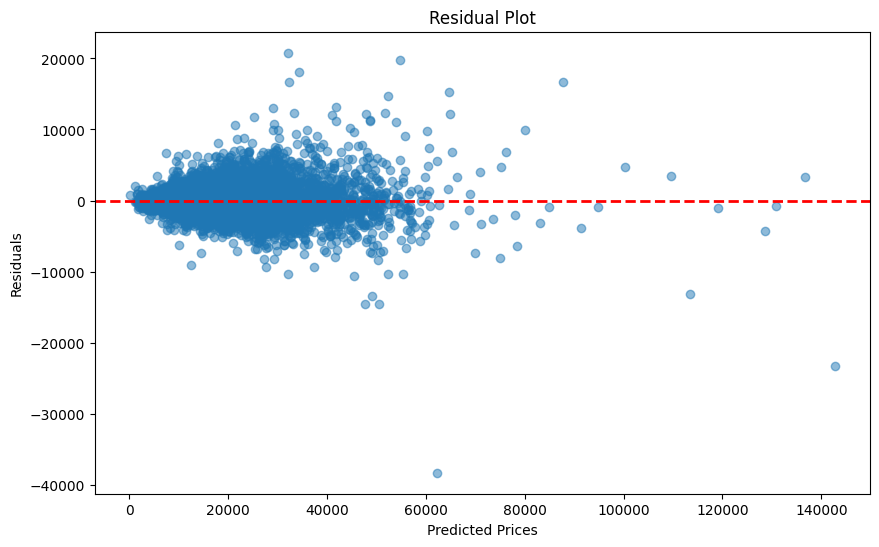

In [29]:
#Residual Plot from XGBoost Tuned Model
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
residuals = ytest - y_pred_xgb_tuning

# Residual Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_xgb_tuning, residuals, alpha=0.5)
plt.title('Residual Plot')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)  # Horizontal line at y=0 for reference
plt.show()


- Residuals are a measure of how far from the regression line data points are. From the residual plots, we can see that the residuals are randomly distributed around the centerline with no obvious pattern. This indicates that the model is able to capture the underlying trend of the data and make good predictions.

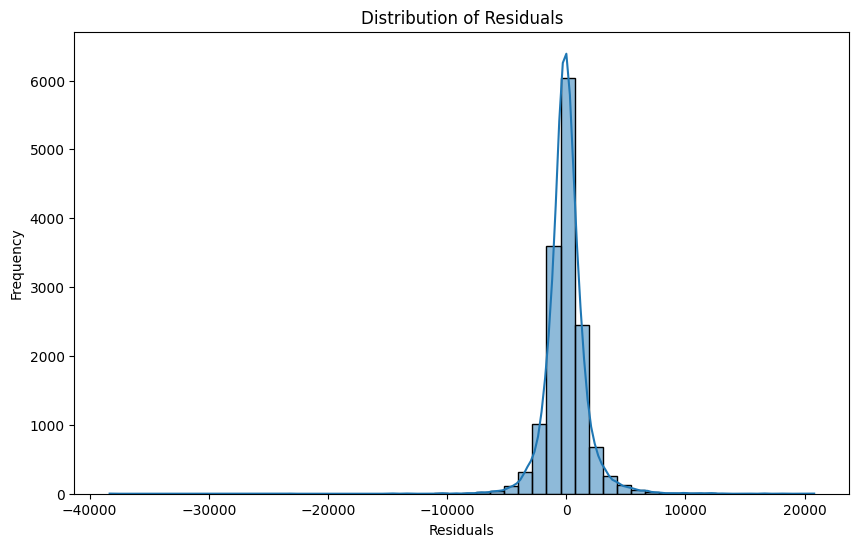

In [32]:

# Distribution of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()




- The distribution of the residuals is also approximately normal, with a mean of 0. This indicates that the model's predictions are unbiased, as the residuals are centered around zero.

## 4.6 Prediction output simulation

Final XGBoost model is used to predict the price of the used car. The prediction is based on the sample random data from the dataset. The prediction output is then compared with the actual price of the used car.

In [35]:
#Sample data test simulation
sample = cars.sample(200)
sample.head()

,model,year,price,transmission,mileage,fuelType,engineSize,tax,mpg,brand
47506,Fabia,2017,9495,Manual,11224,Petrol,1.0,145.0,64.2,Skoda
5843,E Class,2017,20737,Automatic,22122,Diesel,2.0,145.0,65.7,Mercedes
68060,Polo,2016,9995,Manual,27253,Petrol,1.2,20.0,60.1,Volkswagen
60198,Golf,2019,24995,Manual,1903,Petrol,2.0,145.0,37.7,Volkswagen
65136,Passat,2020,27999,Automatic,1000,Diesel,2.0,145.0,52.3,Volkswagen


We're taking random samples from initial data and use it as input for the model. The output of the model is the predicted price of the used car.

In [36]:
#Sample prediction simulation

#Define xgboost from best parameter
xgb_tuning = grid_xgb.best_estimator_

# # Predict price from sample data
sample_pred = xgb_tuning.predict(sample.drop('price', axis=1))


#Print resulting dataframe
result_df = pd.DataFrame({
    'Brand': sample['brand'],
    'Model': sample['model'],
    'Year': sample['year'],
    'Predicted Price': sample_pred,
    'Actual Price': sample['price'],
    'Difference': sample_pred - sample['price'],
    'Error (%)': round(((sample_pred - sample['price']) / sample['price']) * 100, 2)
})
result_df

,Brand,Model,Year,Predicted Price,Actual Price,Difference,Error (%)
47506,Skoda,Fabia,2017,9378.504883,9495,-116.495117,-1.23
5843,Mercedes,E Class,2017,21556.656250,20737,819.656250,3.95
68060,Volkswagen,Polo,2016,9647.027344,9995,-347.972656,-3.48
60198,Volkswagen,Golf,2019,26084.755859,24995,1089.755859,4.36
65136,Volkswagen,Passat,2020,27511.791016,27999,-487.208984,-1.74
...,...,...,...,...,...,...,...
70171,Volkswagen,Tiguan,2016,23265.523438,24990,-1724.476562,-6.90
55882,Toyota,Auris,2015,13045.883789,12000,1045.883789,8.72
55358,Toyota,Auris,2015,10724.567383,9995,729.567383,7.30
59569,Volkswagen,T-Roc,2019,21715.460938,21000,715.460938,3.41


In [86]:
print(f" Total overpriced result: {result_df[result_df['Error (%)'] > 0][['Difference']].sum()} $")
print(f" Total overpriced result: {result_df[result_df['Error (%)'] < 0][['Difference']].sum()} $")
print(f" Total overpriced result: {result_df[['Difference']].sum()} $")


 Total overpriced result: Difference    99174.536133
dtype: float64 $
 Total overpriced result: Difference   -94728.61084
dtype: float64 $
 Total overpriced result: Difference    4445.925293
dtype: float64 $


In [87]:
result_df.groupby(['Brand'])['Error (%)'].mean().sort_values(ascending=False)

Brand
Toyota        2.492174
Mercedes      1.950714
Audi          1.488824
Skoda        -0.409500
Volkswagen   -0.492353
Ford         -0.753617
Name: Error (%), dtype: float64

The model shows better prediction results on certain brands. For example, 
- the model shows <1% error results on Volkswagen, Audi, and Mercedes-Benz. 
- The model shows worse prediction results (>1%) on Skoda, Toyota, and Audi.

### 4.6.2 Profit Analysis Case Study

The final model will be recommended to be used as a helping tool for car procurement agents to make a decision on the price of the used car. The model will be used to predict the price of the used car based on the input of the car's features. The predicted price will be compared with the actual price of the used car. The difference between the predicted price and the actual price will be used to determine the profit of the used car.

Supposed that the company is planning to buy a used car with the following features:
- Model: A3
- Brand: Audi

In [74]:
#Suppose we have a car with the following specifications
target_car = cars[cars['model'] == ' A3'].sample(1, random_state=42)
#Exclude price column
target_car.drop('price', axis=1)


,model,year,transmission,mileage,fuelType,engineSize,tax,mpg,brand
43845,A3,2016,Manual,11318,Petrol,1.4,30.0,55.4,Audi


In [81]:
target_car['price']

43845    15499
Name: price, dtype: int64

Supposed the company is planning to sell the car for 20,000.

- The Actual car price  is 15,499 
- The potential profit is 20,000 - 15,499 = 4.501

#### *Scenario 1*

Suppose the buyer agent only bidding for the price as it is the same for the average price.

In [73]:
#Average sales price for Audi A3 
target_car_avg = cars[cars['model'] == ' A3']['price'].mean()
target_car_avg

17425.57988475642

- The gross profit from the used car will be Target Selling Price - Average Price = 20,000 - 17425.57 = 2574.43
- The loss profit opportunity is 4.501 - 1926.57 = -1922.07

#### *Scenario 2*

Suppose the buyer agent are equipped with the prediction model in bidding the buying price from the owner.

In [85]:
#Predict the price of the target car
target_car_pred = xgb_tuning.predict(target_car)
print(f'The Predicted car price  is {target_car_pred}')
print(f'The Actual car price  is {target_car["price"].values}')

The Predicted car price  is [16068.365]
The Actual car price  is [15499]


- The gross profit from the used car will be Target Selling Price - Predicted Price = 20,000.00 - 16,068.36 = 3931.64
- The loss profit opportunity is 4.501 - 3931.64 = - 426.64

### *Case Study Results*

> - By using "traditional" method, the company will lose 1922.07 in profit opportunity.
> - By using the prediction model, the company will only lose 426.64 in profit opportunity.
> - The use of prediction model will increase the profit opportunity by 1495.43 or **78% on a single transaction**.


---

## 4.7 Conclusion



Conclusion from EDA:
- Certain brands have higher average prices, such as and Mercedes-Benz.
- Newer cars tend to have higher average sales prices, reflecting the common expectation that the value of a car decreases over time.
- Cars with lower mileage tend to have higher average sales prices, reflecting the common expectation that the value of a car decreases as it is driven more.

Conclusion from ML Modeling:
- From the 7 model we've tested, XGBoost Regressor is found to be the best model with the lowest MAPE of 7% and R2 of 96.8%.
- With errors as low as 7.02 % from model prediction output, the company can make well-informed decisions when acquiring used cars, optimizing the balance between competitive pricing and maintaining healthy profit margins.
- The model shows better prediction results on certain brands. For example, the model shows <1% error results on Volkswagen,  and Mercedes-Benz. The model shows worse prediction results (>1%) on Skoda, Toyota, and Audi.


Conclusion from Profit Analysis Case Study:
- The use of prediction model will potentially increase the profit opportunity by 1495.43 or **78% on a single transaction**.

## 4.8 Recommendations

- The model is better suited to predict the price of used cars from certain brands such as Volkswagen, and Mercedes-Benz.
- Data Enrichment for Improved Brand Predictions, Expand the dataset to include more data points for other brands, especially those where the model currently exhibits higher prediction errors (e.g., Skoda, Toyota, Audi).
- Feature Addition for Comprehensive Insights, Improve the model by introducing additional features such as car condition, previous ownership history, and accident records to provide a more comprehensive understanding of factors influencing used car prices.
- Profit Optimization through Negotiation, Leverage the model's predicted base price during negotiations with car sellers. If the actual sales price surpasses the predicted price, the company stands to maximize profit margins, aligning with strategic financial goals
- Forecasting Sales for a Car Dealership, Implement sales forecasting by multiplying the average selling price by the anticipated number of vehicles to be sold. This straightforward formula provides a revenue/sales forecast, aiding in strategic planning for the dealership's financial objectives.

---

In [ ]:
#Save the model
# import pickle
# pickle.dump(xgb_tuning, open('model_xgb_tuning.pkl', 'wb'))


--- 
<div align="center"> END OF NOTEBOOK </div>